In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

# Parsing Helpers

In [3]:
def load_market_data(file, row_limit = None):
    md = pd.read_csv(file,sep=';')
    rename_columns = {'bid_price_1': 'bid', 'ask_price_1': 'ask', 'bid_volume_1': 'bid_sz', 'ask_volume_1': 'ask_sz'}
    md.rename(columns=rename_columns, inplace=True)
    if row_limit:
        markets = split_data_by_product(md.loc[md.timestamp <= row_limit])
    else:
        markets = split_data_by_product(md)
    symbols = list(markets.keys())
    print(f"Symbols: {symbols}")
    return markets

def split_data_by_product(df):
    markets = dict()
    df_grouped = df.groupby("product")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

In [119]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")
    empty_regex = re.compile(r"(\d+) ")
    
    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
            match = empty_regex.match(l)
            if match:
                trading_states.append(match.group(1))
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": -1, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            
    positions = pd.DataFrame(positions)
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100 or t['timestamp'] == time:
                t['true_time'] = time-100 # Duplicates will be removed and first will be kept
                market_trades.append(t)

    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return

def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    market_trades.drop_duplicates(subset=['price', 'quantity', 'symbol', 'timestamp'], inplace=True)
    market_trades['timestamp'] = market_trades['true_time']
    market_trades.drop(columns=['true_time'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """    
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    df['side'] = df.apply(lambda x: np.sign(x['quantity']), axis=1)
    return df


def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum',
                                                                 'buy_vol':'sum','sell_vol':'sum','grey_vol':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'}).drop(columns=['notional'])
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    quote['volume'].fillna(0, inplace=True)
    for col in ['buy_vol', 'sell_vol','grey_vol', 'trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote


def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.duplicated(subset=['symbol','timestamp','price', 'side'])
    fills['active_qty'] = fills['active']*fills['quantity']
    fills['passive_qty'] = (~fills['active'])*fills['quantity']

    fill_data = fills.groupby(['symbol','timestamp','price', 'side'])[['quantity','active_qty','passive_qty']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    orders = orders.merge(fill_data, how='left', on=['symbol','timestamp','price','side'])
    return orders


def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    quote = combine_quote_trades(quote, market_trades.copy())
    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['quote'] = quote 
    dfs['order_depths'] = order_depths
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    
    if by_symbol:
        for table in dfs:
            dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs


def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

# Experimental
def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

# Data Loading

In [120]:
file_name = "068803d5-0175-4576-8fd8-4d64894c54e2"
file_name = "baseline"

log_file = "logs/{}.log".format(file_name)
results_file = "results/{}.csv".format(file_name)

dfs = load_data_from_log(log_file)
results = load_market_data(results_file)
symbols = ['BANANAS', 'PEARLS']

Symbols: ['BANANAS', 'PEARLS']


In [195]:
trades = dfs['market_trades']['PEARLS'].copy()
quote_md = dfs['order_depths']['PEARLS'].copy()

In [197]:
trades.loc[trades.quantity < 0]

,price,quantity,symbol,timestamp,bid,ask,bid_sz,ask_sz,mid_price,side


In [196]:
quote_md

,timestamp,symbol,bid_levels,bid,bid_sz,bid_2,bid_sz_2,bid_5,bid_sz_5,bid_4,...,ask_sz_3,ask_2,ask_sz_2,mid_price,volume,buy_vol,sell_vol,grey_vol,vwap,trades
0,0,PEARLS,2,9998.0,1,9995.0,30.0,NaN,NaN,NaN,...,NaN,NaN,NaN,10001.5,0.0,0.0,0.0,0.0,10001.5,0.0
1,100,PEARLS,2,9996.0,1,9995.0,30.0,NaN,NaN,NaN,...,30.0,10004.0,1.0,9999.0,1.0,0.0,1.0,0.0,10002.0,1.0
2,200,PEARLS,2,9996.0,1,9995.0,21.0,NaN,NaN,NaN,...,NaN,10005.0,21.0,10000.0,0.0,0.0,0.0,0.0,10000.0,0.0
3,300,PEARLS,2,9996.0,2,9995.0,23.0,NaN,NaN,NaN,...,23.0,10004.0,2.0,9997.0,0.0,0.0,0.0,0.0,9997.0,0.0
4,400,PEARLS,3,9998.0,5,9996.0,2.0,NaN,NaN,NaN,...,NaN,10005.0,23.0,10001.0,3.0,0.0,3.0,0.0,9998.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,199500,PEARLS,2,9996.0,1,9995.0,21.0,NaN,NaN,NaN,...,21.0,10004.0,1.0,9997.0,4.0,4.0,0.0,0.0,10002.0,2.0
1995,199600,PEARLS,1,9995.0,28,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10000.0,0.0,0.0,0.0,0.0,10000.0,0.0
1996,199700,PEARLS,3,10002.0,1,9996.0,2.0,NaN,NaN,NaN,...,NaN,10005.0,28.0,10003.0,0.0,0.0,0.0,0.0,10003.0,0.0
1997,199800,PEARLS,2,9996.0,1,9995.0,27.0,NaN,NaN,NaN,...,NaN,10005.0,27.0,10000.0,1.0,1.0,0.0,0.0,10002.0,1.0


# Market Microstructure Analysis
- Spread Distribution
- Quote Size
- Notional
- Toxicity

In [131]:
def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

def md_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in [5, 10, 25, 50, 100]:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['quote_wgt_px_3'] = md.apply(quote_weighted_px_full, levels=3, axis=1) 
    md['quote_wgt_px_full'] = md.apply(quote_weighted_px_full, axis=1)
    
    for t in [1, 2, 3, 4, 5, 10, 30, 100, 200]:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'px_move_{t}'].fillna(0, inplace=True)
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)
    # Volume
    for t in [5, 10, 20, 30, 50]:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels
    md['vol_imb'] = (md.buy_vol/(md.buy_vol+md.sell_vol)).fillna(0.5)
    
    
    ############# Future
    # Future prices
    for t in [1, 5, 10, 20, 30, 50, 100, 200]:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.ask
    for t in [1, 5, 10, 20, 30, 50, 100, 200]:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    
    return

def high_level_summary(sym, quote):
    print(sym)
    summary = quote.agg({
        'spread':['mean','std'], 
        'mid_price': 'std', 
        'px_move_1':'mean',
        'volume':'sum',
        'trades':'sum',
        'bid_sz': 'mean', 
        'ask_sz':'mean', 
        'bid_sz_2': 'mean',
        'ask_sz_2': 'mean',
    })
    display(summary)

In [191]:
mid_labels = []
bid_labels = []
ask_labels = []

for t in [1, 5, 10, 20, 30, 50, 100, 200]:
    mid_labels.append(f'fpx_move_{t}')
    bid_labels.append(f'fpx_bid_move_{t}')
    ask_labels.append(f'fpx_ask_move_{t}')

In [150]:
sym = symbols[0]
print(sym)
quote = dfs['order_depths'][sym].copy()
md_preprocess(quote)

BANANAS


In [192]:
print(quote.columns)

Index(['timestamp', 'symbol', 'bid_levels', 'bid', 'bid_sz', 'bid_2',
       'bid_sz_2', 'bid_5', 'bid_sz_5', 'bid_4',
       ...
       'fpx_move_100', 'fpx_bid_move_100', 'fpx_ask_move_100', 'fpx_move_200',
       'fpx_bid_move_200', 'fpx_ask_move_200', 'dist_fair_full', 'dist_fair_3',
       'dist_fair_bid', 'dist_fair_ask'],
      dtype='object', length=124)


In [187]:
quote['dist_fair_full'] = quote['quote_wgt_px_full']-quote['mid_price']
quote['dist_fair_3'] = quote['quote_wgt_px_3']-quote['mid_price']

quote['dist_fair_bid'] = quote['quote_wgt_px_full']-quote['bid']
quote['dist_fair_ask'] = quote['quote_wgt_px_full']-quote['ask']

In [153]:
high_level_summary(sym, quote)

BANANAS


,spread,mid_price,px_move_1,volume,trades,bid_sz,ask_sz,bid_sz_2,ask_sz_2
mean,5.308154,NaN,-0.008754,NaN,NaN,17.551276,17.782391,23.063946,21.993046
std,1.897812,7.960266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,1329.0,520.0,NaN,NaN,NaN,NaN


In [154]:
display(quote.loc[quote.volume > 0].groupby('spread')[['volume','quote_imb','levels_imb','vol_imb']].mean())
quote.loc[quote.volume > 0].groupby('spread').size()

,volume,quote_imb,levels_imb,vol_imb
spread,,,,
1.0,3.159091,0.594528,-0.568182,0.532197
2.0,3.432432,0.243305,0.783784,0.478378
3.0,1.000000,0.876265,-1.500000,0.666667
4.0,1.440000,0.355635,0.040000,0.520000
5.0,2.200000,0.734872,-0.828571,0.494127
6.0,2.861635,0.388685,0.333333,0.715758
7.0,2.861111,0.497418,0.000000,0.678977


spread
1.0     44
2.0     37
3.0      6
4.0     25
5.0     70
6.0    159
7.0    144
dtype: int64

In [155]:
pd.merge(left = quote.groupby('bid_levels').size().rename('counts_bid'), 
         right = quote.groupby('ask_levels').size().rename('counts_ask'), 
         left_index=True, right_index=True)

,counts_bid,counts_ask
bid_levels,,
1,1264,1280
2,656,610
3,73,107
4,6,2


In [149]:
quote[['bid','ask','mid_price','ask_sz','bid_sz','quote_wgt_px_full', 'dist_fair_full']]

,bid,ask,mid_price,ask_sz,bid_sz,quote_wgt_px_full,dist_fair_full
0,9998.0,10005.0,10001.5,30,1,9999.967213,-1.532787
1,9996.0,10002.0,9999.0,6,1,10000.176471,1.176471
2,9996.0,10004.0,10000.0,1,1,10000.000000,0.000000
3,9996.0,9998.0,9997.0,3,2,9999.886792,2.886792
4,9998.0,10004.0,10001.0,2,5,9999.818182,-1.181818
...,...,...,...,...,...,...,...
1994,9996.0,9998.0,9997.0,2,1,9999.913043,2.913043
1995,9995.0,10005.0,10000.0,28,28,10000.000000,0.000000
1996,10002.0,10004.0,10003.0,2,1,10000.032787,-2.967213
1997,9996.0,10004.0,10000.0,1,1,10000.000000,0.000000


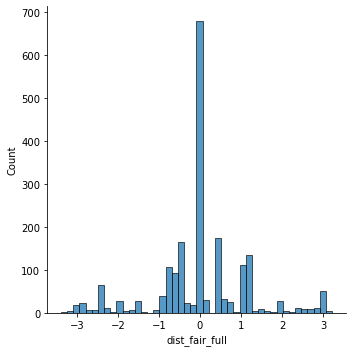

In [156]:
sns.displot(x='dist_fair_full', data=quote)

In [194]:
# sub_data = quote.loc[np.abs(quote.dist_fair_full) > 1].copy()
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_full', 'dist_fair_3'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 1999 100.00%


,quote_imb,levels_imb,dist_fair_full,dist_fair_3,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100,fpx_move_200
quote_imb,1.000,-0.897,0.736,0.734,0.374,0.318,0.304,0.225,0.220,0.182,0.186,0.156
levels_imb,-0.897,1.000,-0.826,-0.810,-0.438,-0.368,-0.341,-0.274,-0.247,-0.214,-0.208,-0.171
dist_fair_full,0.736,-0.826,1.000,0.992,0.534,0.464,0.433,0.380,0.340,0.284,0.257,0.221
dist_fair_3,0.734,-0.810,0.992,1.000,0.534,0.460,0.432,0.378,0.340,0.279,0.254,0.216
fpx_move_1,0.374,-0.438,0.534,0.534,1.000,0.382,0.312,0.273,0.254,0.202,0.173,0.132
fpx_move_5,0.318,-0.368,0.464,0.460,0.382,1.000,0.422,0.346,0.280,0.235,0.186,0.155
fpx_move_10,0.304,-0.341,0.433,0.432,0.312,0.422,1.000,0.432,0.390,0.311,0.258,0.214
fpx_move_20,0.225,-0.274,0.380,0.378,0.273,0.346,0.432,1.000,0.493,0.385,0.292,0.256
fpx_move_30,0.220,-0.247,0.340,0.340,0.254,0.280,0.390,0.493,1.000,0.521,0.343,0.293
fpx_move_50,0.182,-0.214,0.284,0.279,0.202,0.235,0.311,0.385,0.521,1.000,0.433,0.335


In [15]:
sub_data = quote.loc[np.abs(quote.volume) > 2].copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'vol_imb', 'fpx_move_1', 'fpx_move_5',
       'fpx_move_10', 'fpx_move_20', 'fpx_move_30', 'fpx_move_50',
       'fpx_move_100', 'fpx_move_200', 'fpx_1', 'fpx_5', 'fpx_10', 'fpx_20',
       'fpx_30', 'fpx_50', 'fpx_100', 'fpx_200']].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 89 4.45%


,quote_imb,levels_imb,vol_imb,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100,fpx_move_200,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100,fpx_200
quote_imb,1.000,-0.002,0.031,0.088,0.142,0.093,0.146,0.032,0.108,0.049,0.136,0.209,0.306,0.190,0.217,0.140,0.263,0.275,0.297
levels_imb,-0.002,1.000,-0.154,-0.653,-0.613,-0.701,-0.728,-0.687,-0.600,-0.731,-0.663,-0.674,-0.680,-0.725,-0.669,-0.689,-0.652,-0.708,-0.703
vol_imb,0.031,-0.154,1.000,0.045,0.156,0.056,0.001,0.024,-0.087,0.067,0.083,0.091,0.130,0.082,0.018,0.085,-0.011,0.146,0.177
fpx_move_1,0.088,-0.653,0.045,1.000,0.376,0.459,0.491,0.529,0.465,0.449,0.361,0.882,0.471,0.510,0.531,0.538,0.510,0.519,0.480
fpx_move_5,0.142,-0.613,0.156,0.376,1.000,0.452,0.432,0.385,0.488,0.625,0.523,0.355,0.849,0.517,0.465,0.426,0.451,0.566,0.542
fpx_move_10,0.093,-0.701,0.056,0.459,0.452,1.000,0.561,0.449,0.458,0.561,0.521,0.533,0.559,0.860,0.545,0.465,0.525,0.576,0.496
fpx_move_20,0.146,-0.728,0.001,0.491,0.432,0.561,1.000,0.534,0.463,0.607,0.474,0.539,0.552,0.554,0.844,0.548,0.543,0.615,0.519
fpx_move_30,0.032,-0.687,0.024,0.529,0.385,0.449,0.534,1.000,0.516,0.578,0.550,0.516,0.484,0.469,0.548,0.857,0.570,0.564,0.549
fpx_move_50,0.108,-0.600,-0.087,0.465,0.488,0.458,0.463,0.516,1.000,0.422,0.609,0.525,0.544,0.447,0.451,0.536,0.842,0.466,0.577
fpx_move_100,0.049,-0.731,0.067,0.449,0.625,0.561,0.607,0.578,0.422,1.000,0.539,0.458,0.671,0.566,0.620,0.556,0.489,0.868,0.559


In [16]:
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['spread', 'volume', 'volume_5', 'volume_10', 'volume_20',
       'volume_30', 'volume_50']].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1999 1999 100.00%


,spread,volume,volume_5,volume_10,volume_20,volume_30,volume_50
spread,1.000,-0.055,-0.003,0.020,0.015,0.011,-0.002
volume,-0.055,1.000,0.444,0.315,0.224,0.161,0.142
volume_5,-0.003,0.444,1.000,0.703,0.503,0.380,0.324
volume_10,0.020,0.315,0.703,1.000,0.709,0.546,0.455
volume_20,0.015,0.224,0.503,0.709,1.000,0.808,0.628
volume_30,0.011,0.161,0.380,0.546,0.808,1.000,0.762
volume_50,-0.002,0.142,0.324,0.455,0.628,0.762,1.000


# Plotting

In [17]:
fig_size = (6,3)
def plot_quote(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "bid", data=md, color="red")
    ax.plot("timestamp", "ask", data=md, color="blue")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (Seashells)")
    ax.set_title(sym)
    return
    
def plot_cum_volume(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    data = md['volume'].cumsum()
    ax.plot(data, linestyle='-.')
    ax.set_xlabel("Time")
    ax.set_ylabel("Volume")
    ax.set_title(sym)
    return
    
def plot_spread(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "spread", data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel("Spread")
    ax.set_title(sym)
    return

def plot_price(md, sym, price_type):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", price_type, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(price_type.capitalize())
    ax.set_title(sym)
    return

def plot_ohcl(md, sym):
    # Candlestick plot
    pass

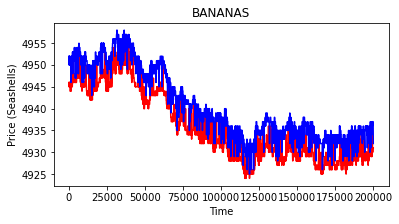

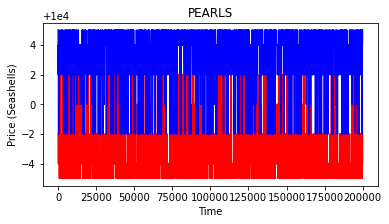

In [18]:
for s in symbols:
    plot_quote(dfs['quote'][s], s)
    # plot_price(markets[s], s, "mid_px_mavg10")

# Regression

In [42]:
from sklearn.linear_model import LogisticRegression

In [179]:
features = ['dist_fair_full']
labels = []
for t in [1, 5, 10, 20, 30, 50, 100]:
    labels.append(f'fpx_move_{t}')

In [180]:
total_samples = len(quote)

In [181]:
train_samples = total_samples//4

train_data = quote.iloc[:train_samples][features+labels]
X_train = train_data[features].values
clfs = {}


for t in [1, 5, 10, 20, 30, 50, 100]:
    y_train = train_data[f'fpx_move_{t}'].values
    clfs[t] = LogisticRegression(random_state=0).fit(X_train, y_train)

In [182]:
for t in [50]:
    probs = clfs[t].predict_proba(X_train)
    train_data[f'predict_{t}'] = clfs[t].classes_[probs.argmax(axis=1)]
    train_data[f'predict_prob_{t}'] = probs.max(axis=1)
    # print(clfs[t].score(X_train, y_train[t]))

In [183]:
train_data['correct'] = train_data['predict_50'] == train_data['fpx_move_50']

In [184]:
train_data['correct'].mean()

0.561122244488978

In [185]:
train_data.loc[train_data['predict_prob_50'] > 0.65]['correct'].mean()

0.75

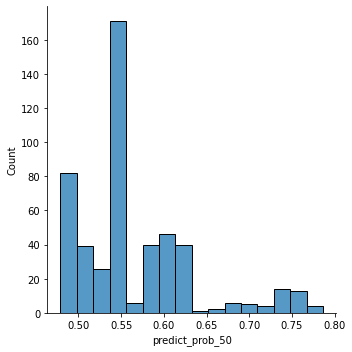

In [186]:
sns.displot(train_data['predict_prob_50'])